<hr>
<h2>> LOAD IN THE LIBRARIES AND DATA</h2>
<hr>

In [7]:
# Basic 

import os
import random
import re
import math
import time
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join

# Scikit-learn

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score

# Deep Learning

from tqdm import tqdm
from tqdm.keras import TqdmCallback
import tensorflow as tf, re, math
import tensorflow.keras.backend as K
from tensorflow.keras.layers import *
import efficientnet.tfkeras as efn
from keras import layers
from keras.applications import DenseNet121
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam

# Visualization

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly
import plotly.express as px
from plotly.tools import FigureFactory as FF
from plotly.offline import iplot
import seaborn as sns
%matplotlib inline

# Misc

from PIL import Image
import cufflinks
import cv2 as cv
import warnings
warnings.simplefilter('ignore')

In [8]:
# Setting file paths for our notebook:

base_path = r'C:\Users\HIMANSHU\Downloads\Melanoma jpg'

train_img_path = r'C:\Users\HIMANSHU\Downloads\Melanoma jpg\train'
train_images = [f for f in listdir(train_img_path) if isfile(join(train_img_path, f))]

test_img_path = r'C:\Users\HIMANSHU\Downloads\Melanoma jpg\test'
test_images = [f for f in listdir(test_img_path) if isfile(join(test_img_path, f))]

img_stats_path = r'C:\Users\HIMANSHU\Downloads\Melanoma Dataset'

In [9]:
# Loading train and test data.

train = pd.read_csv(os.path.join(base_path, 'train.csv'))
test = pd.read_csv(os.path.join(base_path, 'test.csv'))
sample = pd.read_csv(os.path.join(base_path, 'sample_submission.csv'))

<hr>
<h1>> EXPLORATORY DATA ANALYSIS </h1>
<hr>

In [10]:
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000


In [11]:
test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,width,height
0,ISIC_0052060,IP_3579794,male,70.0,NaN,6000,4000
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,6000,4000
2,ISIC_0058510,IP_7960270,female,55.0,torso,6000,4000
3,ISIC_0073313,IP_6375035,female,50.0,torso,6000,4000
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,1920,1080


In [12]:
# Removing unnecessary columns:

train.drop(columns=['tfrecord', 'width', 'height'], inplace=True)
test.drop(columns=['width', 'height'], inplace=True)

In [13]:
# Renaming train/test columns:

train.columns = [
    'img_name', 'id', 'sex', 'age', 'location', 'diagnosis',
    'benign_malignant', 'target'
]
test.columns = ['img_name', 'id', 'sex', 'age', 'location']

In [14]:
# Lets take a look at columns

print('Train Data columns: \n')
print(train.columns)
print('')
print('Test Data columns: \n')
print(test.columns)

Train Data columns: 

Index(['img_name', 'id', 'sex', 'age', 'location', 'diagnosis',
       'benign_malignant', 'target'],
      dtype='object')

Test Data columns: 

Index(['img_name', 'id', 'sex', 'age', 'location'], dtype='object')


<hr>
<h2> > Description of Dataset :-</h2>
<hr>
<h4>image name -> the filename of specific image for the train set</h4>
<h4>patient_id -> identifies the unique patient</h4>
<h4>sex -> gender of the patient</h4>
<h4>age_approx -> approx age of the patient at time of scanning</h4>
<h4>anatom_site_general_challenge -> location of the scan site</h4>
<h4>diagnosis -> information about the diagnosis</h4>
<h4>benign_malignant - indicates scan result if it's malignant or benign</h4>
<h4>target -> same as above but better for modelling since it's binary</h4>
<hr>

In [15]:
# Data-types

print('Train Data types: \n')
print(train.dtypes)

Train Data types: 

img_name             object
id                   object
sex                  object
age                 float64
location             object
diagnosis            object
benign_malignant     object
target                int64
dtype: object


In [16]:
# Brief description of data

train.describe(include='all')

,img_name,id,sex,age,location,diagnosis,benign_malignant,target
count,33126,33126,33061,33058.000000,32599,33126,33126,33126.000000
unique,33126,2056,2,NaN,6,9,2,NaN
top,ISIC_6495137,IP_7279968,male,NaN,torso,unknown,benign,NaN
freq,1,115,17080,NaN,16845,27124,32542,NaN
mean,NaN,NaN,NaN,48.870016,NaN,NaN,NaN,0.017630
std,NaN,NaN,NaN,14.380360,NaN,NaN,NaN,0.131603
min,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,40.000000,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,50.000000,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,60.000000,NaN,NaN,NaN,0.000000


In [17]:
train['sex'].value_counts()

male      17080
female    15981
Name: sex, dtype: int64

In [18]:
train['age'].value_counts()

45.0    4466
50.0    4270
55.0    3824
40.0    3576
60.0    3240
35.0    2850
65.0    2527
30.0    2358
70.0    1968
25.0    1544
75.0     981
20.0     655
80.0     419
85.0     149
15.0     132
90.0      80
10.0      17
0.0        2
Name: age, dtype: int64

In [19]:
# Different classes for 'diagnosis'

train['diagnosis'].value_counts()

unknown                               27124
nevus                                  5193
melanoma                                584
seborrheic keratosis                    135
lentigo NOS                              44
lichenoid keratosis                      37
solar lentigo                             7
atypical melanocytic proliferation        1
cafe-au-lait macule                       1
Name: diagnosis, dtype: int64

In [20]:
train['location'].value_counts()

torso              16845
lower extremity     8417
upper extremity     4983
head/neck           1855
palms/soles          375
oral/genital         124
Name: location, dtype: int64

In [21]:
train['benign_malignant'].value_counts()

benign       32542
malignant      584
Name: benign_malignant, dtype: int64

<hr>
<h2>ANALYSIS :-</h2>
<ol>
    <li>'img_name' = Names of images, single patient can have multiple images (33,126)<\li>
    <li>'id' = ID, unqiue for all (2056)<\li>
    <li>'sex' = Males are more than Women (2)<\li>
    <li>'age' = Mean age is 48.87, most are between 40 and 60<\li>
    <li>'location' = Mainly on Torso (7)<\li>
    <li>'diagnosis' = There are 10 different classes<\li>
    <li>'benign_malignant' = Whether Benign or Malignant, most are benign (2)<\li>
    <li>'target' = Same as above, just binary (2)<\li>
<\ol>
<hr>

In [22]:
# test.describe(include='all')

<hr>
<h2>> MISSING VALUES</h2>
<hr>

In [23]:
# Checking for null values

print('Null values in Train: ')
print(train.isnull().sum())
print('')
print('Null values in Test: ')
print(test.isnull().sum())

Null values in Train: 
img_name              0
id                    0
sex                  65
age                  68
location            527
diagnosis             0
benign_malignant      0
target                0
dtype: int64

Null values in Test: 
img_name      0
id            0
sex           0
age           0
location    351
dtype: int64


<hr><h3>We have small portion of missing values for age and sex I think there is no harm if we impute them with the most frequent ones, meanwhile body parts missing on both datasets, we better be set 'unknown' for missing values for this one </h3><hr>

Text(0.5, 1.0, 'Test Data Missing Values')

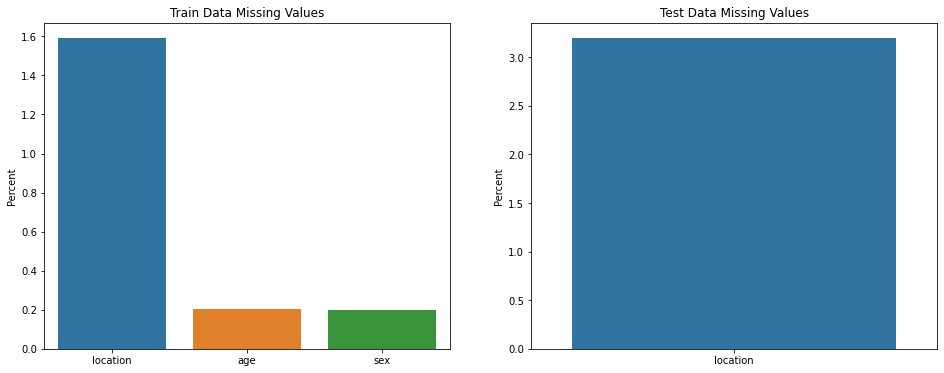

In [24]:
# Checking missing values:

def missing_percentage(df):

    total = df.isnull().sum().sort_values(
        ascending=False)[df.isnull().sum().sort_values(ascending=False) != 0]
    percent = (df.isnull().sum().sort_values(ascending=False) / len(df) *
               100)[(df.isnull().sum().sort_values(ascending=False) / len(df) *
                     100) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])


missing_train = missing_percentage(train)
missing_test = missing_percentage(test)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(x=missing_train.index,
            y='Percent',
            data=missing_train,
            ax=ax[0])

sns.barplot(x=missing_test.index,
            y='Percent',
            data=missing_test,
            ax=ax[1])

ax[0].set_title('Train Data Missing Values')
ax[1].set_title('Test Data Missing Values')

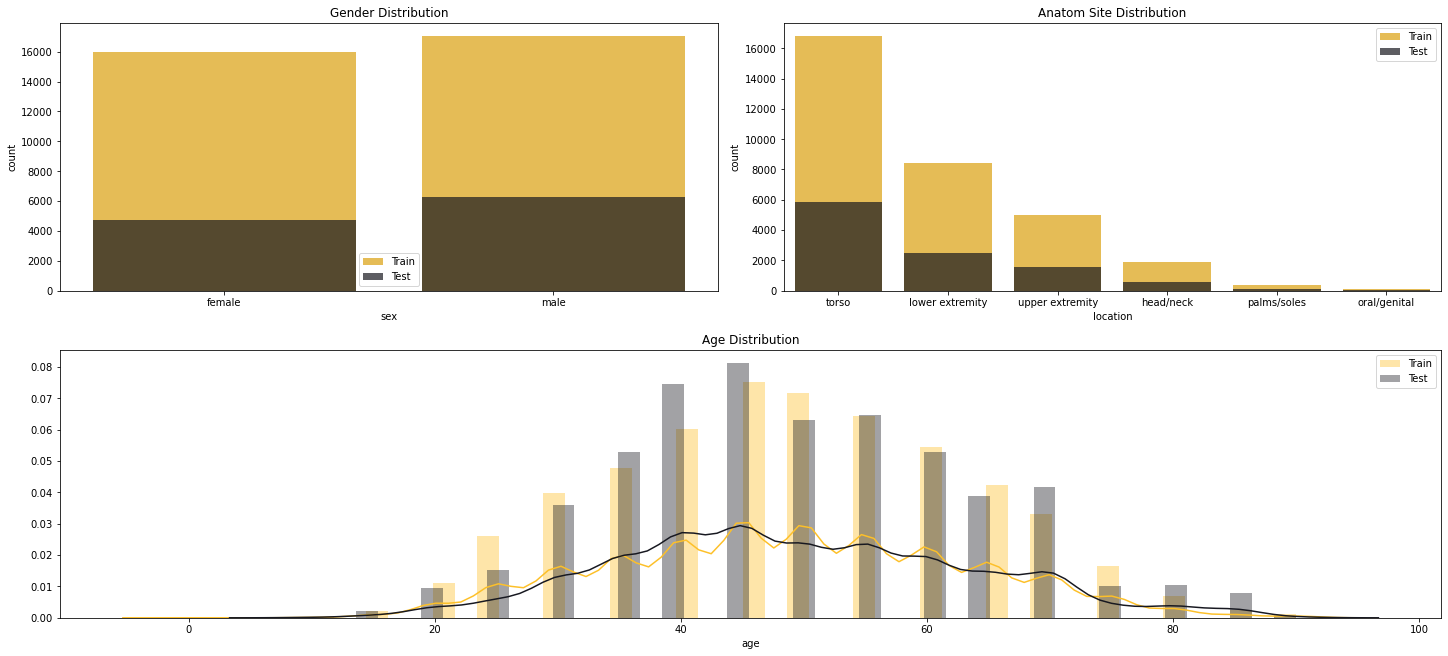

In [25]:
# Creating a customized chart and giving in figsize etc.

fig = plt.figure(constrained_layout=True, figsize=(20, 9))

# Creating a grid:

grid = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)

ax1 = fig.add_subplot(grid[0, :2])

# Set the title.

ax1.set_title('Gender Distribution')

sns.countplot(train.sex.sort_values(ignore_index=True),
              alpha=0.9,
              ax=ax1,
              color='#fdc029',
              label='Train')
sns.countplot(test.sex.sort_values(ignore_index=True),
              alpha=0.7,
              ax=ax1,
              color='#171820',
              label='Test')
ax1.legend()

# Customizing the second grid.

ax2 = fig.add_subplot(grid[0, 2:])

# Plot the countplot.

sns.countplot(train.location,
              alpha=0.9,
              ax=ax2,
              color='#fdc029',
              label='Train',
              order=train['location'].value_counts().index)
sns.countplot(test.location,
              alpha=0.7,
              ax=ax2,
              color='#171820',
              label='Test',
              order=test['location'].value_counts().index), ax2.set_title(
                  'Anatom Site Distribution')

ax2.legend()

# Customizing the third grid.

ax3 = fig.add_subplot(grid[1, :])

# Set the title.

ax3.set_title('Age Distribution')

# Plot the histogram.

sns.distplot(train.age, ax=ax3, label='Train', color='#fdc029')
sns.distplot(test.age, ax=ax3, label='Test', color='#171820')

ax3.legend()

plt.show()

In [26]:
# Filling missing anatom site values with 'unknown' tag:

for df in [train, test]:
    df['location'].fillna('unknown', inplace=True)

In [27]:
# Filling age and sex with appropriate values.

train['sex'].fillna(train['sex'].mode()[0], inplace=True)

train['age'].fillna(train['age'].median(), inplace=True)

In [28]:
# Checking missing value counts:

print(
    f'Train missing value count: {train.isnull().sum().sum()}\nTest missing value count: {train.isnull().sum().sum()}'
)

Train missing value count: 0
Test missing value count: 0


<hr>
<h2>> Working With Images</h2>
<hr>

Examples WITH Melanoma



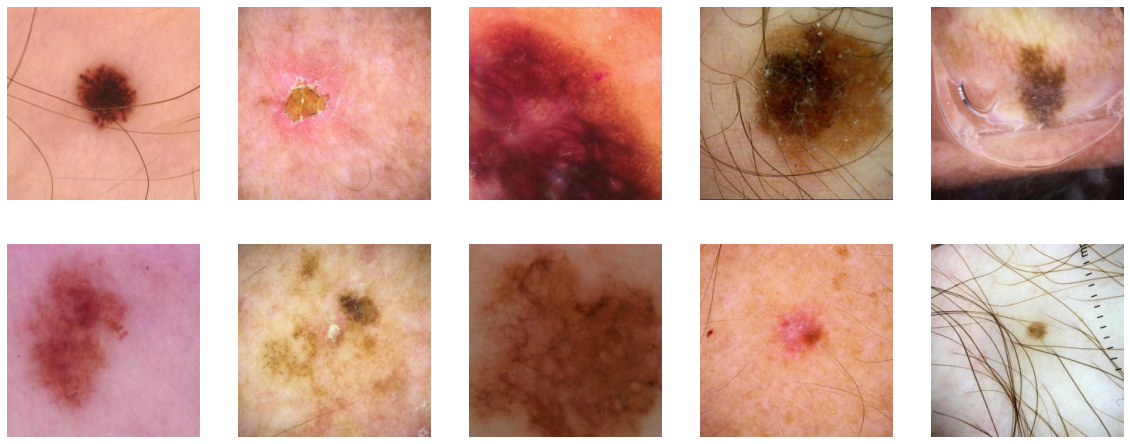


Examples WITHOUT Melanoma


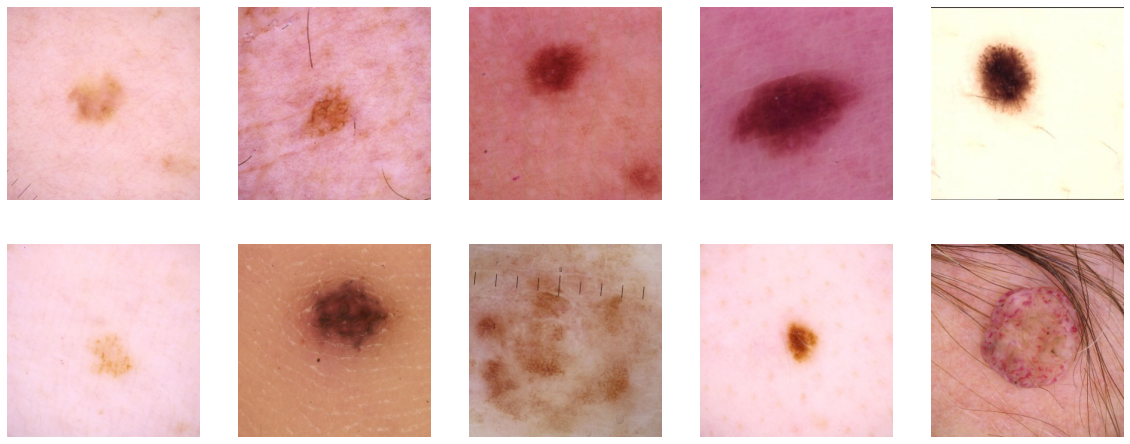

In [30]:
import cv2, pandas as pd, matplotlib.pyplot as plt

train = pd.read_csv(r'C:\Users\HIMANSHU\Downloads\Melanoma jpg\train.csv')
print('Examples WITH Melanoma')
print('')
imgs = train.loc[train.target==1].sample(10).image_name.values
plt.figure(figsize=(20,8))

for i,k in enumerate(imgs):
    img = cv2.imread(r'C:\Users\HIMANSHU\Downloads\Melanoma jpg\train\%s.jpg'%k)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    plt.subplot(2,5,i+1); plt.axis('off')
    plt.imshow(img)
plt.show()

print('')
print('Examples WITHOUT Melanoma')
imgs = train.loc[train.target==0].sample(10).image_name.values
plt.figure(figsize=(20,8))
for i,k in enumerate(imgs):
    img = cv2.imread(r'C:\Users\HIMANSHU\Downloads\Melanoma jpg\train\%s.jpg'%k)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    plt.subplot(2,5,i+1); plt.axis('off')
    plt.imshow(img)
plt.show()